In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm_notebook, trange
from numba import jit
from mpl_toolkits.mplot3d import Axes3D
from collections import Counter
from sklearn.decomposition import PCA
import math
from matplotlib.patches import Ellipse
from sklearn.cluster import SpectralClustering
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.cluster import DBSCAN
from sklearn.manifold import MDS
import seaborn as sns
import matplotlib
import scipy.stats as st
from sklearn.preprocessing import MinMaxScaler

In [5]:
os.chdir(r"/raid6/roozbeh/trip_similarity/")

In [6]:
with pd.HDFStore("koln_by_hour_OD_and_scaled.h5") as store:
    OD8df = store["OD8df"]
    OD8df_scaled = store["OD8df_scaled"]
    OD12df = store["OD12df"]
    OD12df_scaled = store["OD12df_scaled"]
    OD16df = store["OD16df"]
    OD16df_scaled = store["OD16df_scaled"]
    OD20df = store["OD20df"]
    OD20df_scaled = store["OD20df_scaled"]

In [7]:
def get_trip_spatial_similarity_from_tuple_scaled_wgm(t1,t2):
    odist = np.sqrt( (t1[1] - t2[1]) ** 2 + (t1[2] - t2[2])**2 )
    ddist = np.sqrt( (t1[4] - t2[4]) ** 2 + (t1[5] - t2[5])**2 )

    sim = 1./(1+odist) + 1./(1+ddist)
    return(sim/2)

In [8]:
def get_trip_temporal_similarity_from_tuple_scaled_wgm(t1,t2):
    ot = np.absolute(t1[0]-t2[0])
    dt = np.absolute(t1[3]-t2[3])

    sim = 1./(1+ot) + 1./(1+dt)
    return(sim/2)

In [9]:
w_x = 0.6
w_t = 1 - w_x
def combined_spatio_temporal_similarity(t1,t2):
    sp = get_trip_spatial_similarity_from_tuple_scaled_wgm(t1,t2)
    tm = get_trip_temporal_similarity_from_tuple_scaled_wgm(t1,t2)
    
    return (np.exp(w_x * np.log(sp) + w_t * np.log(tm) ))

In [10]:
cyc_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [11]:
matplotlib.rcParams.update({'font.size': 12})

In [12]:
sample8scaled = OD8df_scaled.sample(n=2000,random_state=54321)
sample8 = OD8df.sample(n=2000,random_state=54321)

In [13]:
similarities8 = pairwise_distances(sample8scaled,metric=combined_spatio_temporal_similarity,n_jobs=-1)

In [14]:
distances8 = 1 - similarities8

In [15]:
similarities8_gkern = np.exp(-4 * distances8  )

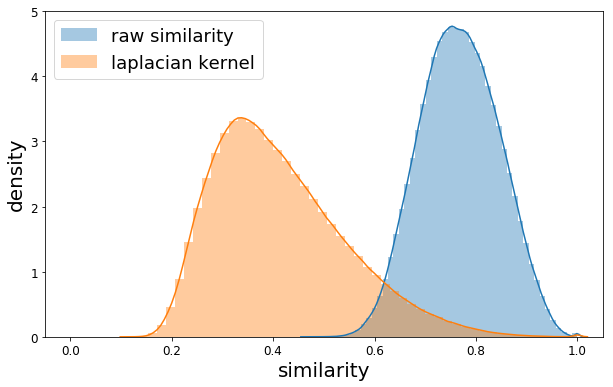

In [16]:
plt.figure(figsize=(10,6))
ax =  sns.distplot(np.reshape(similarities8,-1),norm_hist=True,label="raw similarity")
ax =  sns.distplot(np.reshape(similarities8_gkern,-1),norm_hist=True,ax=ax,label="laplacian kernel")
ax.set_xlabel("similarity",fontsize=20)
ax.set_xlim((-0.05,1.05))
ax.set_ylabel("density",fontsize=20)
plt.legend(prop= {"size" : 18})
plt.show()

In [17]:
dbs_obj = DBSCAN(metric="precomputed",n_jobs=-1,min_samples=3,eps=0.075)

In [18]:
mds_obj = MDS(n_jobs=-1,dissimilarity='precomputed')

In [19]:
spc_obj = SpectralClustering(affinity='precomputed',n_jobs=-1,assign_labels="kmeans",random_state=54321)

In [20]:
pca_obj = PCA(n_components=2)

In [21]:
pca_obj.fit(OD8df_scaled)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [22]:
pca_obj.explained_variance_ratio_

array([ 0.62049667,  0.2061206 ])

In [23]:
dbs_obj.fit(distances8)

DBSCAN(algorithm='auto', eps=0.075, leaf_size=30, metric='precomputed',
    metric_params=None, min_samples=3, n_jobs=-1, p=None)

In [24]:
Counter(dbs_obj.labels_)

Counter({-1: 76, 0: 1875, 1: 7, 2: 5, 3: 9, 4: 15, 5: 3, 6: 3, 7: 4, 8: 3})

In [25]:
mds_obj.fit(distances8)

MDS(dissimilarity='precomputed', eps=0.001, max_iter=300, metric=True,
  n_components=2, n_init=4, n_jobs=-1, random_state=None, verbose=0)

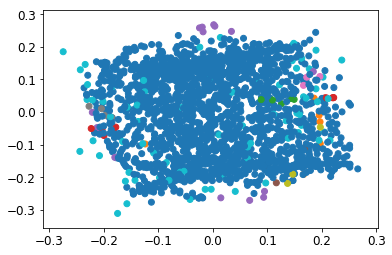

In [26]:
plt.scatter(mds_obj.embedding_[:,0],mds_obj.embedding_[:,1],c=[cyc_colors[lbl%len(cyc_colors)] for lbl in dbs_obj.labels_])
plt.show()

In [27]:
spc_obj.fit(similarities8)

SpectralClustering(affinity='precomputed', assign_labels='kmeans', coef0=1,
          degree=3, eigen_solver=None, eigen_tol=0.0, gamma=1.0,
          kernel_params=None, n_clusters=8, n_init=10, n_jobs=-1,
          n_neighbors=10, random_state=54321)

In [28]:
Counter(spc_obj.labels_)

Counter({0: 220, 1: 342, 2: 303, 3: 322, 4: 305, 5: 192, 6: 179, 7: 137})

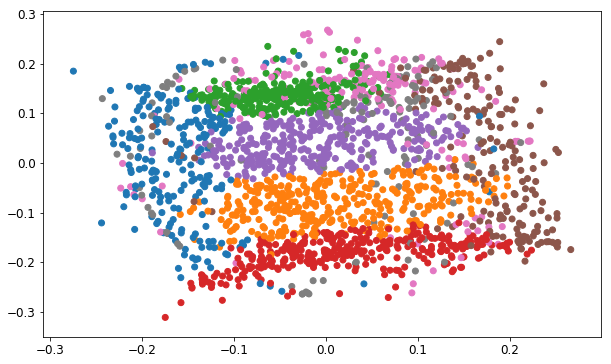

In [29]:
plt.figure(figsize=(10,6))
plt.scatter(mds_obj.embedding_[:,0],mds_obj.embedding_[:,1],c=[cyc_colors[lbl%len(cyc_colors)] for lbl in spc_obj.labels_])
plt.show()

In [30]:
spc_obj.fit(similarities8_gkern)

SpectralClustering(affinity='precomputed', assign_labels='kmeans', coef0=1,
          degree=3, eigen_solver=None, eigen_tol=0.0, gamma=1.0,
          kernel_params=None, n_clusters=8, n_init=10, n_jobs=-1,
          n_neighbors=10, random_state=54321)

In [31]:
Counter(spc_obj.labels_)

Counter({0: 204, 1: 251, 2: 227, 3: 356, 4: 273, 5: 212, 6: 277, 7: 200})

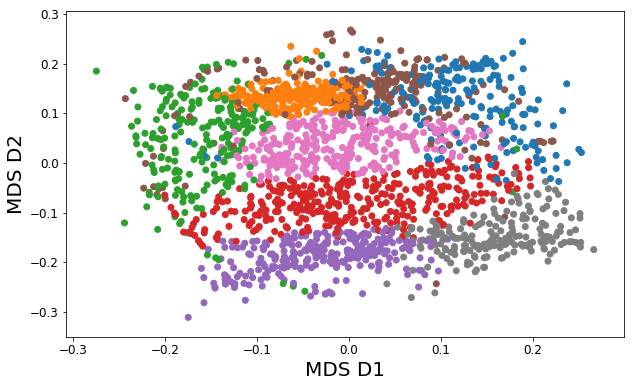

In [32]:
plt.figure(figsize=(10,6))

plt.scatter(mds_obj.embedding_[:,0],mds_obj.embedding_[:,1],c=[cyc_colors[lbl%len(cyc_colors)] for lbl in spc_obj.labels_])
ax = plt.gca()
ax.set_xlabel("MDS D1",fontsize=20)
ax.set_ylabel("MDS D2",fontsize=20)
plt.show()

In [33]:
pca_projection = pca_obj.transform(sample8scaled)

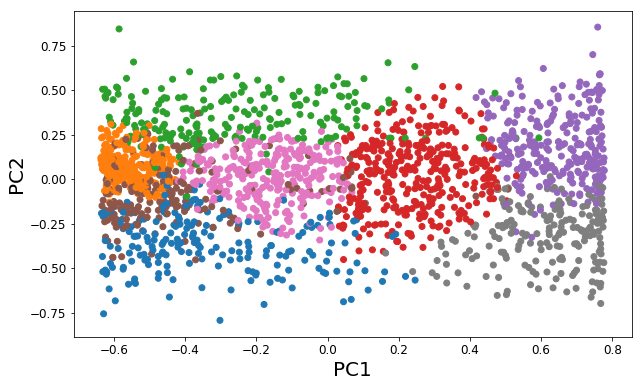

In [34]:
plt.figure(figsize=(10,6))
plt.scatter(pca_projection[:,0],pca_projection[:,1],c=[cyc_colors[lbl] for lbl in spc_obj.labels_])
ax = plt.gca()
ax.set_xlabel("PC1",fontsize=20)
ax.set_ylabel("PC2",fontsize=20)
plt.show()

In [35]:
cluster0 = sample8scaled[spc_obj.labels_ == 0]
cluster1 = sample8scaled[spc_obj.labels_ == 1]
cluster2 = sample8scaled[spc_obj.labels_ == 2]
cluster3 = sample8scaled[spc_obj.labels_ == 3]
cluster4 = sample8scaled[spc_obj.labels_ == 4]
cluster5 = sample8scaled[spc_obj.labels_ == 5]
cluster6 = sample8scaled[spc_obj.labels_ == 6]
cluster7 = sample8scaled[spc_obj.labels_ == 7]

In [36]:
def get_ellipse(cluster0,clr):
    data_x = cluster0.x_begin.append(cluster0.x_end)
    data_y = cluster0.y_begin.append(cluster0.y_end)

    avg_x = np.mean(data_x)
    avg_y = np.mean(data_y)
    x_diff = data_x - avg_x
    y_diff = data_y - avg_y
    x_diff_sq = [i**2 for i in x_diff]
    slope = sum(x*y for x,y in zip(x_diff,y_diff)) / sum(x_diff_sq)
    return(Ellipse((avg_x,avg_y),2*data_x.std(),2*data_y.std(),math.degrees(math.atan(slope)),facecolor='none',lw=1,edgecolor=clr))

In [37]:
plt.figure(figsize=(10,6))
ax = plt.subplot(111,aspect='equal')
ax.set_xlim(0,1)
ax.set_ylim(0.1,0.8)
ax.scatter(np.mean(cluster0.x_begin),np.mean(cluster0.y_begin),c=cyc_colors[0])
ax.scatter(np.mean(cluster0.x_end),np.mean(cluster0.y_end),c=cyc_colors[0],marker='s')
ax.add_artist(get_ellipse(cluster0,cyc_colors[0]))
ax.scatter(np.mean(cluster1.x_begin),np.mean(cluster1.y_begin),c=cyc_colors[1])
ax.scatter(np.mean(cluster1.x_end),np.mean(cluster1.y_end),c=cyc_colors[1],marker='s')
ax.add_artist(get_ellipse(cluster1,cyc_colors[1]))
ax.scatter(np.mean(cluster2.x_begin),np.mean(cluster2.y_begin),c=cyc_colors[2])
ax.scatter(np.mean(cluster2.x_end),np.mean(cluster2.y_end),c=cyc_colors[2],marker='s')
ax.add_artist(get_ellipse(cluster2,cyc_colors[2]))
ax.scatter(np.mean(cluster3.x_begin),np.mean(cluster3.y_begin),c=cyc_colors[3])
ax.scatter(np.mean(cluster3.x_end),np.mean(cluster3.y_end),c=cyc_colors[3],marker='s')
ax.add_artist(get_ellipse(cluster3,cyc_colors[3]))
ax.scatter(np.mean(cluster4.x_begin),np.mean(cluster4.y_begin),c=cyc_colors[4])
ax.scatter(np.mean(cluster4.x_end),np.mean(cluster4.y_end),c=cyc_colors[4],marker='s')
ax.add_artist(get_ellipse(cluster4,cyc_colors[4]))
ax.scatter(np.mean(cluster5.x_begin),np.mean(cluster5.y_begin),c=cyc_colors[5])
ax.scatter(np.mean(cluster5.x_end),np.mean(cluster5.y_end),c=cyc_colors[5],marker='s')
ax.add_artist(get_ellipse(cluster5,cyc_colors[5]))
ax.scatter(np.mean(cluster6.x_begin),np.mean(cluster6.y_begin),c=cyc_colors[6])
ax.scatter(np.mean(cluster6.x_end),np.mean(cluster6.y_end),c=cyc_colors[6],marker='s')
ax.add_artist(get_ellipse(cluster6,cyc_colors[6]))
ax.scatter(np.mean(cluster7.x_begin),np.mean(cluster7.y_begin),c=cyc_colors[7])
ax.scatter(np.mean(cluster7.x_end),np.mean(cluster7.y_end),c=cyc_colors[7],marker='s')
ax.add_artist(get_ellipse(cluster7,cyc_colors[7]))

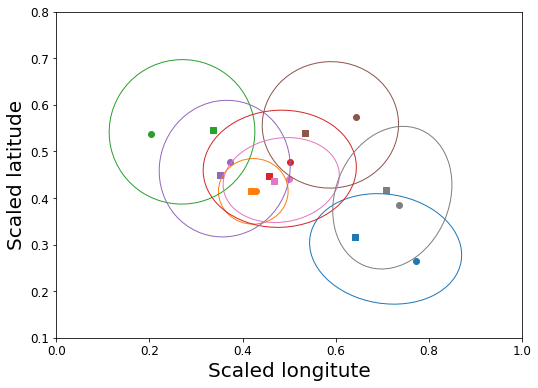

In [38]:
ax.set_xlabel("Scaled longitute",fontsize=20)
ax.set_ylabel("Scaled latitude",fontsize=20)
plt.show()

In [39]:
plt.figure(figsize=(10,6))
ax = sns.distplot(cluster0.time_begin,hist=False,kde_kws={'bw' : 0.05})
ax = sns.distplot(cluster1.time_begin,ax=ax,hist=False,kde_kws={'bw' : 0.05})
ax = sns.distplot(cluster2.time_begin,ax=ax,hist=False,kde_kws={'bw' : 0.05})
ax = sns.distplot(cluster3.time_begin,ax=ax,hist=False,kde_kws={'bw' : 0.05})
ax = sns.distplot(cluster4.time_begin,ax=ax,hist=False,kde_kws={'bw' : 0.05})
ax = sns.distplot(cluster5.time_begin,ax=ax,hist=False,kde_kws={'bw' : 0.05})
ax = sns.distplot(cluster6.time_begin,ax=ax,hist=False,kde_kws={'bw' : 0.05})
ax = sns.distplot(cluster7.time_begin,ax=ax,hist=False,kde_kws={'bw' : 0.05})
ax.set_ylim(0,8)
ax.set_ylabel("density",fontsize=20)
ax.set_xlabel("time begin",fontsize=20)

Text(0.5,0,'time begin')

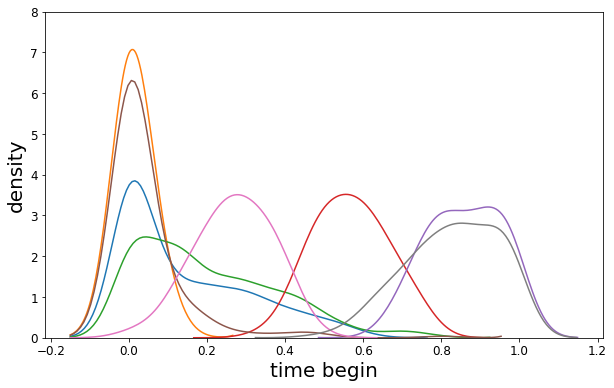

In [40]:
plt.show()

In [41]:
plt.figure(figsize=(10,6))
ax = sns.distplot(cluster0.time_end,hist=False,kde_kws={'bw' : 0.05})
ax = sns.distplot(cluster1.time_end,ax=ax,hist=False,kde_kws={'bw' : 0.05})
ax = sns.distplot(cluster2.time_end,ax=ax,hist=False,kde_kws={'bw' : 0.05})
ax = sns.distplot(cluster3.time_end,ax=ax,hist=False,kde_kws={'bw' : 0.05})
ax = sns.distplot(cluster4.time_end,ax=ax,hist=False,kde_kws={'bw' : 0.05})
ax = sns.distplot(cluster5.time_end,ax=ax,hist=False,kde_kws={'bw' : 0.05})
ax = sns.distplot(cluster6.time_end,ax=ax,hist=False,kde_kws={'bw' : 0.05})
ax = sns.distplot(cluster7.time_end,ax=ax,hist=False,kde_kws={'bw' : 0.05})
ax.set_ylim(0,8)
ax.set_ylabel("density",fontsize=20)
ax.set_xlabel("time end",fontsize=20)

Text(0.5,0,'time end')

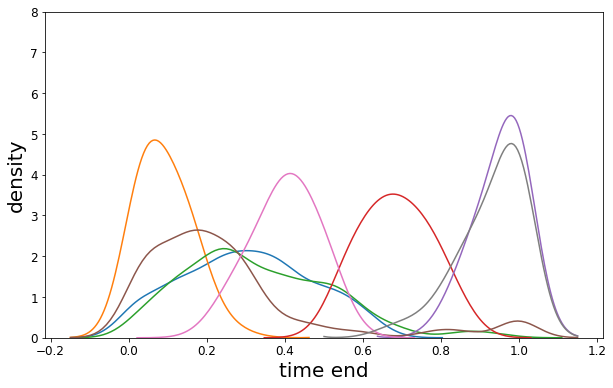

In [42]:
plt.show()